In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Dense
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
# from ROI_extraction import preprocess_image
import cv2
import os
from ROI_extraction import DataGenerator
# Set the path to dataset
dataset_path = '../images/3regimes'

ids = []
labels = {}
classes = {'excess':1,'normal':0,'insufficient':-1}
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path) :
            if filename.endswith((".jpg", ".jpeg", ".png")):
                img_path = os.path.join(class_path, filename) 
                ids.append(img_path)
                labels[img_path]=classes[class_name]

# Shuffle the list of tuples
random.shuffle(ids)

# Define the split ratio (e.g., 80% for training, 20% for validation)
split_ratio = 0.8

# Calculate the index for splitting
split_index = int(len(ids) * split_ratio)

# Split the shuffled IDs and labels into training and validation sets
train_ids = ids[:split_index]
val_ids = ids[split_index:]

In [5]:
# Set the input image dimensions
img_width, img_height = 40, 40
n_channels = 3

params = {'dim': (img_height,img_width),
          'batch_size': 64,
          'n_classes': 3,
          'n_channels': n_channels,
          'shuffle': False}

# Set the number of classes
num_classes = 3

# for class_name in os.listdir(dataset_path):
#     class_path = os.path.join(dataset_path, class_name)
#     if os.path.isdir(class_path):
#         for image_name in os.listdir(class_path):
#             image_path = os.path.join(class_path, image_name)
#             image = cv2.imread(image_path)


# Create the VGG16 model for feature extraction
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_width, img_height, n_channels))

# Freeze the layers of the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Create the top layers for feature extraction
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model for feature extraction
model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])


training_generator = DataGenerator(train_ids, labels, **params)
validation_generator = DataGenerator(val_ids, labels, **params)

# Train the model for feature extraction
history = model.fit(
    training_generator,
    epochs=50,
    validation_data=validation_generator
)

# Unfreeze the upper layers of the convolutional base
for layer in model.layers[0].layers[16:]:
    layer.trainable = True

# Compile the model for fine-tuning
model.compile(optimizer=RMSprop(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model for fine-tuning
history_fine_tuning = model.fit(
    training_generator,
    epochs=100,
    validation_data=validation_generator
)

# Save the trained model
model.save('vgg16_model.h5')

Epoch 1/50
 6/62 [=>............................] - ETA: 5:18 - loss: 0.7484 - accuracy: 0.3229

KeyboardInterrupt: 

In [3]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 40, 40, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 40, 40, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 40, 40, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 20, 20, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 20, 20, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 20, 20, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 10, 10, 128)       0     

1047


NameError: name 'preprocess_image' is not defined

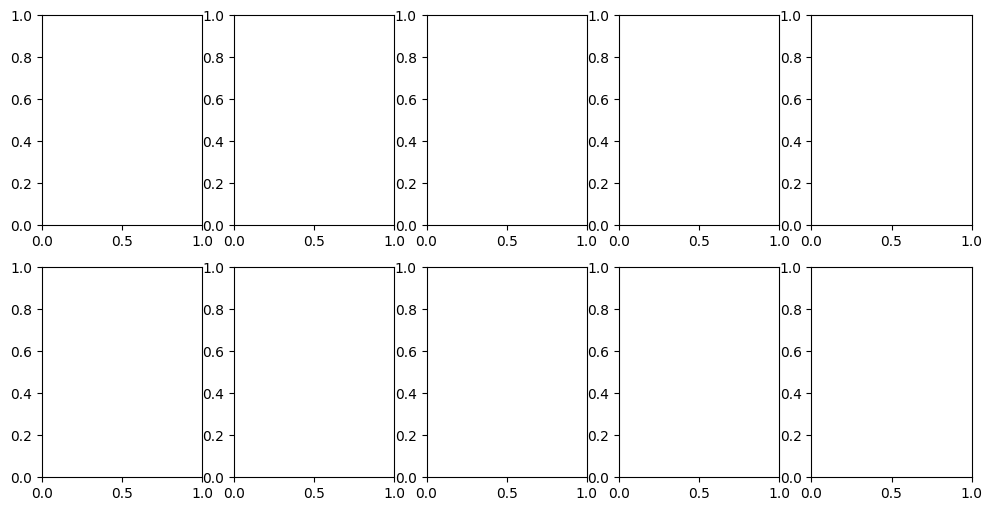

In [4]:
import os
import random
# Define the path to dataset folder
folder_path = '../images/3regimes/excess'

# Collect the paths of all image files in the folder
image_paths = [os.path.join(folder_path, filename) for filename in os.listdir(folder_path) if filename.endswith((".jpg", ".jpeg", ".png"))]

# Create a subplot grid for 10 images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.ravel()

random_numbers = []
for _ in range(10):
    random_numbers.append(random.randint(0, len(image_paths)))

for i,index in enumerate(random_numbers):
    print(index)
    axes[i].imshow(cv2.cvtColor(preprocess_image(cv2.imread(image_paths[index])), cv2.COLOR_BGR2RGB))
    axes[i].axis('off')
plt.tight_layout()
plt.show()